<a href="https://colab.research.google.com/github/souchem23/data-science-coursework/blob/main/Unit4/SoumikC_Unit4Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Part I: Introduction**

For the Unit 4 project, I will be comparing hierarchical and nonhierarchical models to determine **the measure of randomness and variety in a URL** of four different website domains: com, it, net, and org. Particularly, I would like to interpret the correlation between the formation of particular URLS and the chosen domain when crafting a cyber attack.

## Package Installation

In [1]:
# Installing packages
!pip install preliz
import preliz as pz

import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 11.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


#**Part II: Context + Data**

## Context

I found a dataset on Kaggle that described various different malicious URLS, providing stastics for each. One of these statistics was the **URL entropy** (a quantification of the amount of randomness present in each URL). This randomness refers to randomness in the choice of characters, numbers, language, and size of URL.

I chose to compare this entropy across various types of **URL domains**. There are a variety of URL domains such as (.com, .net, .org, .it, .gov). They are used to identify the website AND so that people can access these websites from around the world.

**PURPOSE:**

This project aims to establish a correlation between URL domains and URL entropy, to further provide an insight into attacker behaviors and which domains are commonly used for attacks.

## Data Processing

In order to process the data, I will filter by four domains (com, org, it, net) and display the correlation url_entropy.

In [3]:
# Reading in the data
url_network = 'https://raw.githubusercontent.com/souchem23/data-science-coursework/refs/heads/main/maliciousURLCyberAttack.csv'

# Creating dataframe representation
network = pd.read_csv(url_network)

# Filtering the data
network = network.query("tld == 'com' | tld == 'org' | tld == 'it' | tld=='net'")
network = network.head(10000)

# Assigning entropy as the category
network['tld'] = network['tld'].astype("category")
network = network[['tld', 'url_entropy']]

# Display processed data
network

,tld,url_entropy
3,com,3.640224
4,com,3.935399
5,com,3.916127
6,it,3.675871
9,com,3.368042
...,...,...
17081,com,4.108007
17082,com,3.762267
17083,org,3.251629
17086,com,2.846439


Now, we can plot a histogram in order to view a visualization of our likelihood after data processing.

(array([   5.,   58.,  338., 1547., 3358., 2786., 1283.,  416.,  171.,
          38.]),
 array([1.84237099, 2.18344813, 2.52452528, 2.86560242, 3.20667956,
        3.5477567 , 3.88883384, 4.22991098, 4.57098812, 4.91206526,
        5.2531424 ]),
 <BarContainer object of 10 artists>)

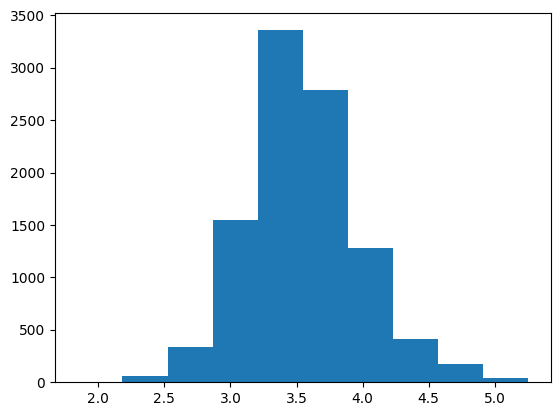

In [ ]:
plt.hist(network['url_entropy'])

Just by looking at the visualization, there seems to be some **skew** that we should take into account, since the left tail is much longer than the right tail.

Next step is to create the categorial representation of the URL domains that we can use to start making our hierarchical and non-hierarchical models.

In [5]:
pos_idx = network.tld.cat.codes.values

#an array of the four strings that represent position
pos_codes = network.tld.cat.categories

#puts coords in a dict, so pymc can read them
network_coords = {"pos": pos_codes}

print(pos_idx)
print(pos_codes)
print(network_coords)

[0 0 0 ... 3 0 3]
Index(['com', 'it', 'net', 'org'], dtype='object')
{'pos': Index(['com', 'it', 'net', 'org'], dtype='object')}


#**Part III: Nonhierarchical Model Creation**

My first step will be to create my nonhierarchical models to make a baseline for comparison against the hierarchical models.

## **Nonhierarchical Model #1**

In [ ]:
with pm.Model(coords = network_coords) as network_model_nh1:

  # Regular priors
  μ = pm.Normal('μ', mu = 3, sigma = 5, dims = "pos")
  σ = pm.HalfNormal('σ', sigma = 5, dims = "pos")
  ν = pm.Exponential('ν', lam = 0.1, dims = "pos")

  # Likelihood
  y = pm.StudentT('y', mu = μ[pos_idx], sigma = σ[pos_idx], nu = ν[pos_idx],
                  observed = network.url_entropy)

  data_network_nh1 = pm.sample()

Output()

Output()

Output()

(0.0, 5.0)

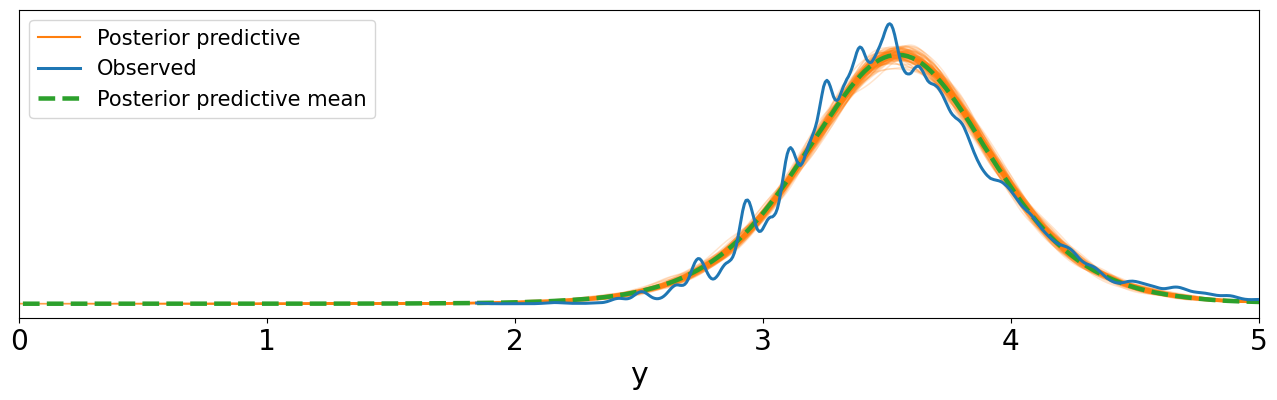

In [ ]:
pm.sample_posterior_predictive(data_network_nh1, model = network_model_nh1, extend_inferencedata=True)
ax = az.plot_ppc(data_network_nh1, num_pp_samples=100, figsize=(16, 4), colors=["C1", "C0", "C2"])
ax.set_xlim(0, 5)

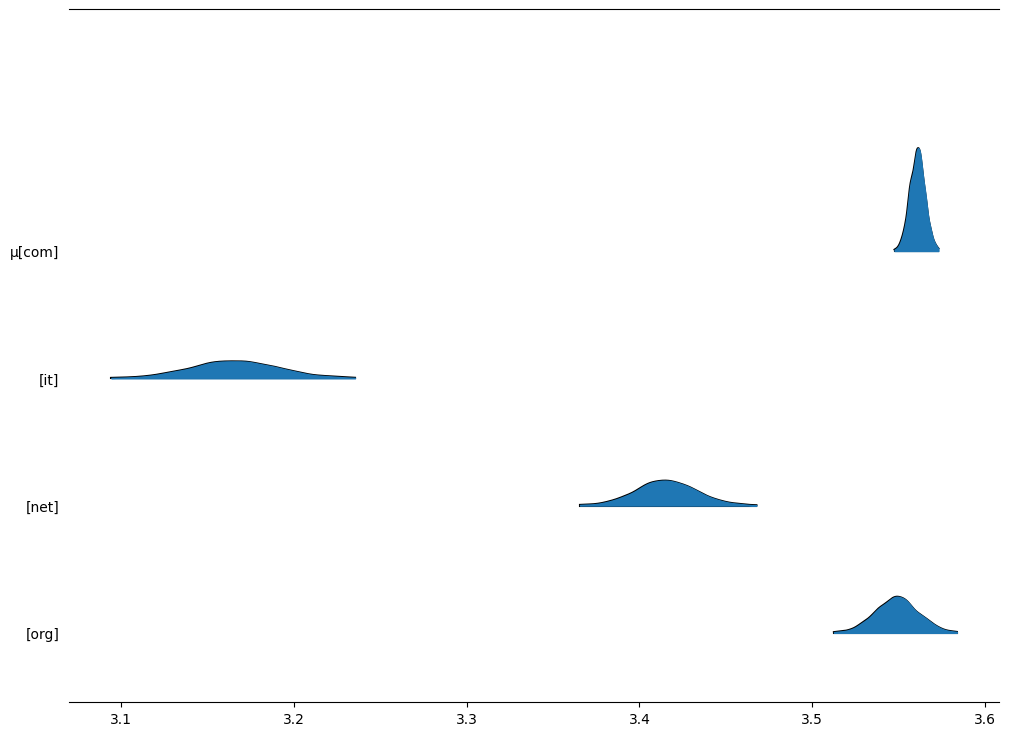

In [ ]:
axes = az.plot_forest(data_network_nh1, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

**This first model is OK.** It's mean matches the mean of the observed data. However, the posterior predictive check shows me that the right side of the model does not match very well with the observed data. Also, near the peak of the graph, the posterior predictive check shows me that the new model does not match well with the observed data, predicting much lower than the actual value.

**Primarily, it does NOT account for any skew.** It does not represent the true nature of the data because I simply used a StudentT model that does not have a skew parameter. I chose to do this to see how a model without skew would perform for this task. I will choose a model with skew for a future nonhierarchical model.

## **Nonhierarchical Model #2**

In [ ]:
with pm.Model(coords = network_coords) as network_model_nh2:

  # Regular priors
  μ = pm.Normal('μ', mu=3, sigma=1, dims = "pos")
  σ = pm.HalfNormal('σ', sigma=0.1, dims = "pos")
  m = pm.Gumbel('ν', mu=-1, beta=0.1, dims = "pos")

  # Likelihood
  y = pm.SkewNormal('y', mu = μ[pos_idx], sigma = σ[pos_idx], alpha = m[pos_idx],
                  observed = network.url_entropy)

  data_network_nh2 = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

(0.0, 5.0)

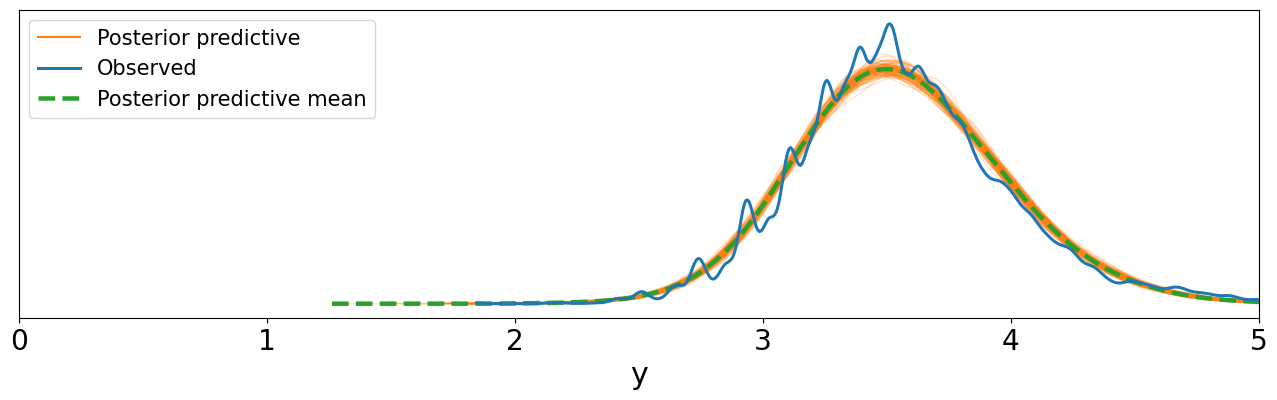

In [ ]:
pm.sample_posterior_predictive(data_network_nh2, model = network_model_nh2, extend_inferencedata=True)
ax = az.plot_ppc(data_network_nh2, num_pp_samples=100, figsize=(16, 4), colors=["C1", "C0", "C2"])
ax.set_xlim(0, 5)

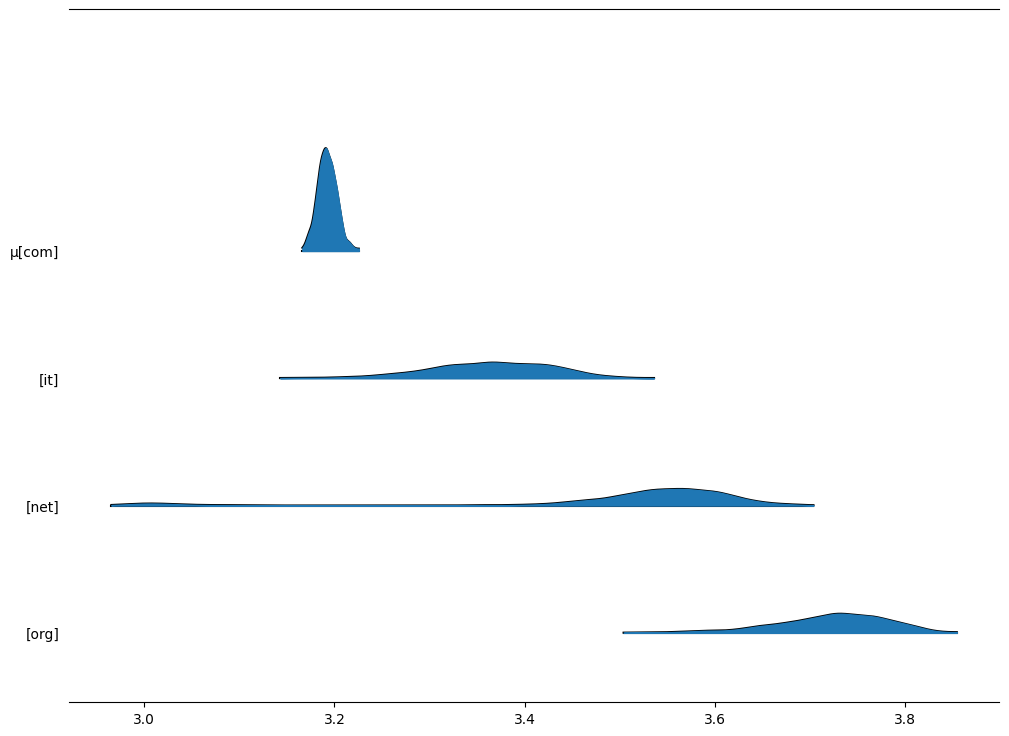

In [ ]:
axes = az.plot_forest(data_network_nh2, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

**This second model is BETTER.** First think to point our is the posterior predictive check better aligns with the observed data. This indicates that our **standard deviation** is much better and our skew matches much more with BOTH the distribution and reality. Yet, the means do not match as well as the first graph since the peak of this new posterior is a lower than the observed data.

I believe that these changes occured because I chose to use a Gumbel distribution for my skewness parameter. Doing so allowed me to actually account for this skew. Additionally, I chose to use "sigma=1" in my "μ" parameter in order to decrease variance for the location of the posterior predictive check.

Let's see if we can do better.

## **Nonhierarchical Model #3**

In [19]:
with pm.Model(coords = network_coords) as network_model_nh3:

  # Regular priors
  μ = pm.Normal('μ', mu=3.5, sigma=1, dims = "pos")
  σ = pm.HalfNormal('σ', sigma=0.1, dims = "pos")
  α_mu = pm.Uniform('α_mu', upper = 1.5, lower = 0.5, dims = "pos")
  β_mu = pm.Uniform('β_mu', upper = 1, lower = 0, dims = "pos")

  # Likelihood
  y = pm.SkewStudentT('y', mu = μ[pos_idx], sigma = σ[pos_idx], a = α_mu[pos_idx], b=β_mu[pos_idx],
                  observed = network.url_entropy)

  data_network_nh3 = pm.sample()

Output()

Output()

Output()

(2.0, 5.0)

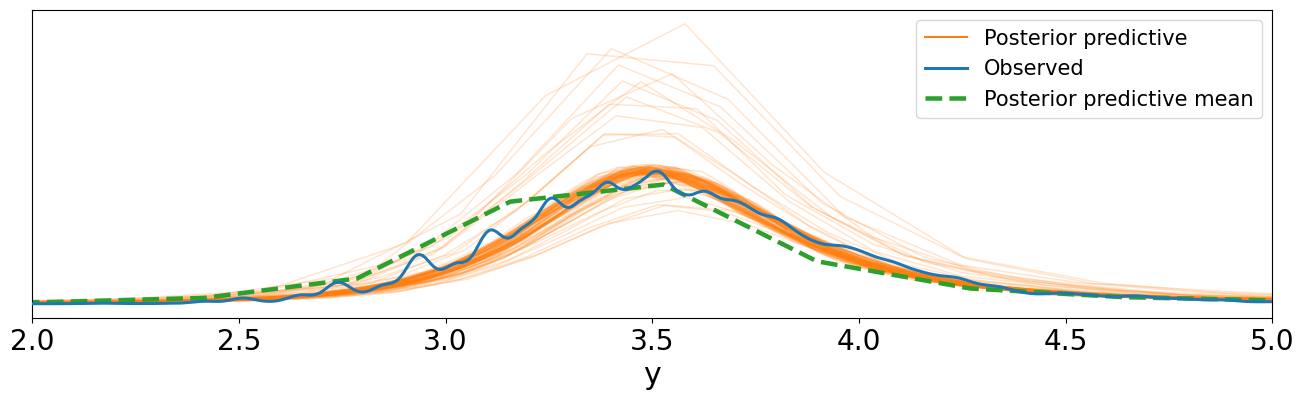

In [ ]:
pm.sample_posterior_predictive(data_network_nh3, model = network_model_nh3, extend_inferencedata=True)
ax = az.plot_ppc(data_network_nh3, num_pp_samples=100, figsize=(16, 4), colors=["C1", "C0", "C2"])
ax.set_xlim(2, 5)

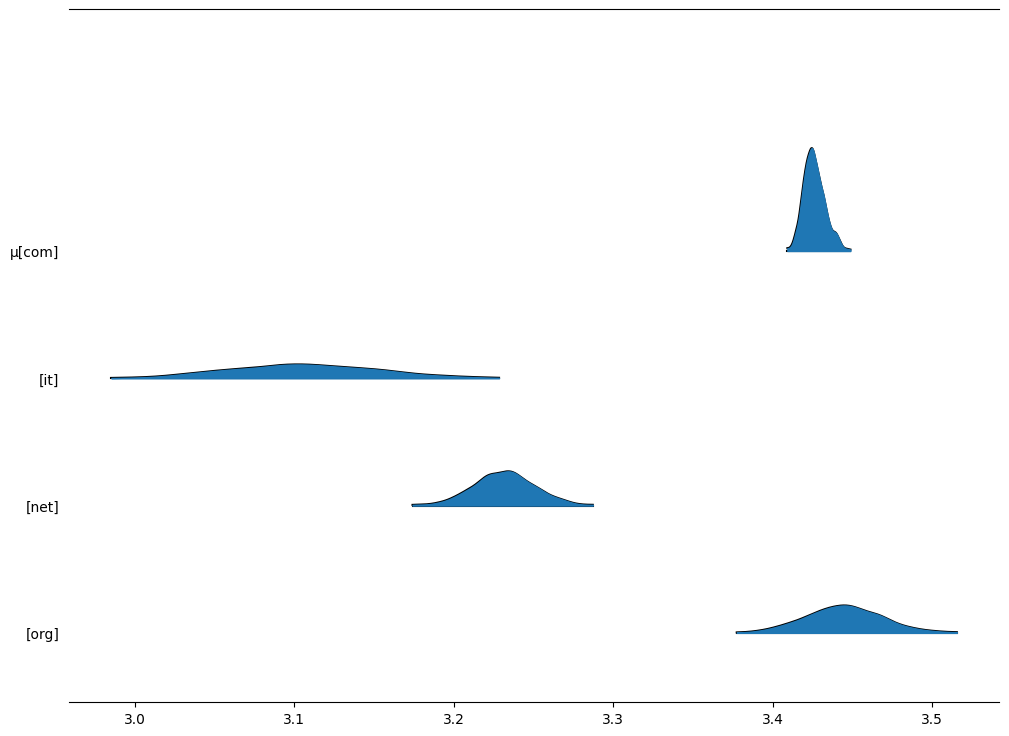

In [ ]:
axes = az.plot_forest(data_network_nh3, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

**I think that this model WILL BE the final nonhierarchical model FOR NOW**. In comparison to the previous non-heirarchical models, this model does a better job accounting for the skew in the observed data. Looking at just the individual samples (not the mean), we can observe that this non-heirarchical model has a similar width to the observed data, showing that the standard deviation is also similar. The most important thing is that this model has the same peak as the observed data, so the mean is very similar. These combined factors made this model slightly better than the previous models.

This is the best that I have gotten thus far, so it will suffice for now.

### Explanation of Priors

For the location parameter (μ), a Normal prior centered at an entropy value of 3 with a standard deviation of 10 was used. This reflects my belief that the entropy values will be around 3. I did not think there would be large variability around the mean becuase attackers would not want to create a URL with an entropy that is too high or too low. Too high or low values would easily be flagged by detecting software. Thus I chose a value of 1 for the "sigma" parameter.

Given this assumption, for the scale parameter (σ), I chose a HalfNormal prior with a standard deviation of 0.1. This way, my data will have a positive standard deviation, but it will be very low given my assumption regarding attackers not changing their behaviors to avoid being caught.

For the shape paramters, I used two uniform distributions because I knew that the model had some skew and it would be positive, but I was not sure by how much it would be in this case. Thus, I gave small values for the upper and lower bounds, but I was not aware of the true context beyond that.

#**Part IIII: Hierarchical Model Creation**

Considering the nonhierarchical models as a baseline (starting point), we can now start creating hierarchical models.

## **Heirarchical Model #1**

In [6]:
with pm.Model(coords=network_coords) as network_model_h:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 3, sigma = 1)
    σ_mu = pm.HalfNormal('σ_mu', sigma = 0.1)
    ν_mu = pm.Exponential('ν_mu', lam = 0.1)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = σ_mu,
                  nu = ν_mu,
                  dims = "pos")

    σ = pm.HalfNormal('σ', sigma = 0.1,
                      dims = "pos")
    v = pm.Exponential('v', lam=0.1, dims="pos")

    #likelihood; same as before
    y = pm.StudentT('y', mu=μ[pos_idx], sigma=σ[pos_idx], nu=v[pos_idx],
                    observed=network["url_entropy"])

    #cs for chemshift, h for heirarchical
    data_network_h1 = pm.sample()


Output()

Output()

Output()

(0.0, 5.0)

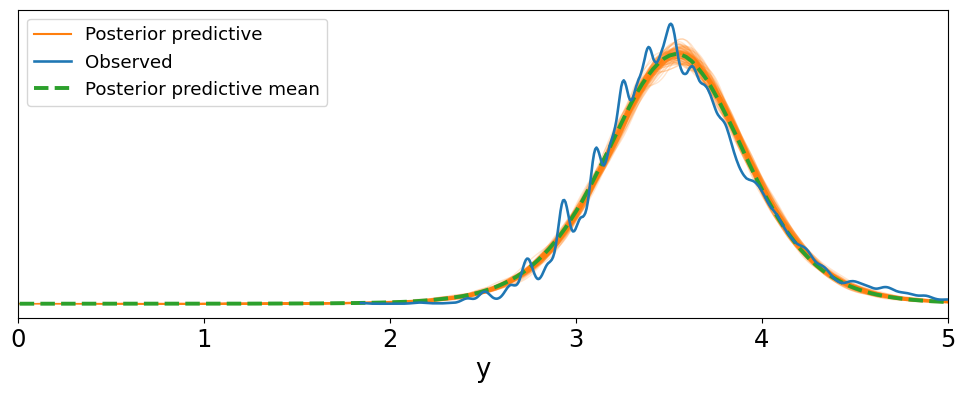

In [ ]:
pm.sample_posterior_predictive(data_network_h1, model=network_model_h, extend_inferencedata=True)

plot = az.plot_ppc(data_network_h1, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])
plot.set_xlim(0, 5)

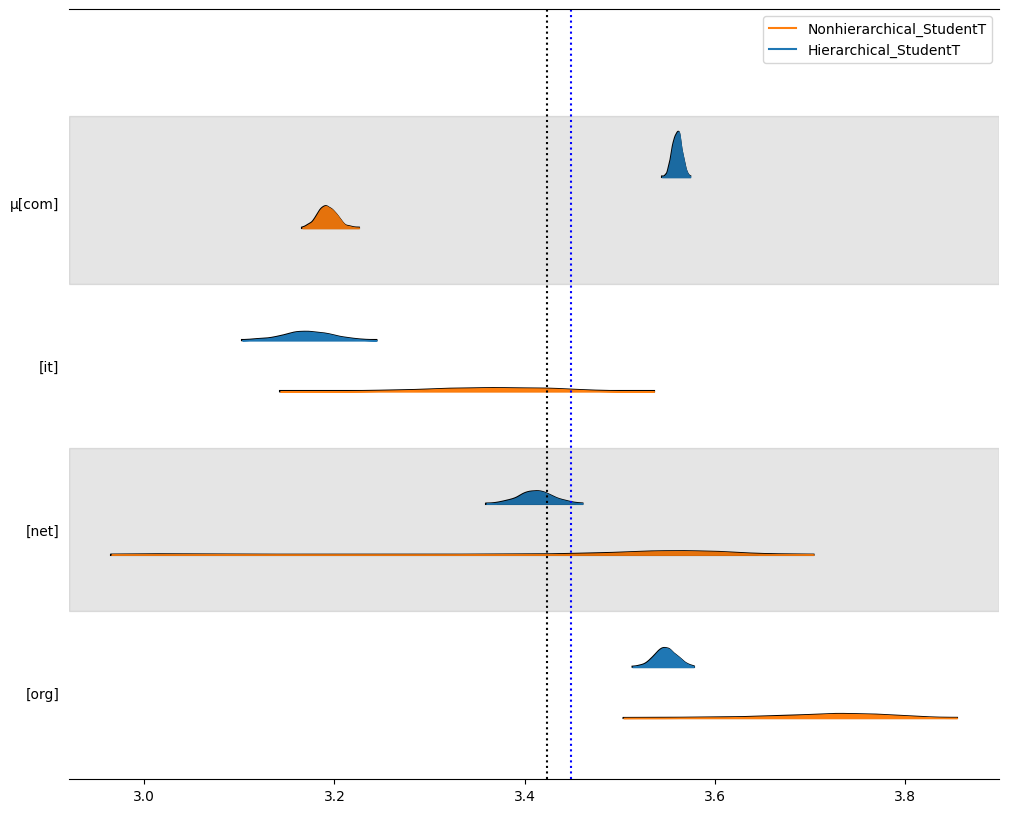

In [ ]:
axes = az.plot_forest([data_network_h1, data_network_nh2], kind="ridgeplot",
                      model_names=['Hierarchical_StudentT', 'Nonhierarchical_StudentT'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

y_lims = axes[0].get_ylim()
axes[0].vlines(data_network_h1.posterior['μ'].mean(), *y_lims, color="k", ls=":");
axes[0].vlines(data_network_nh2.posterior['μ'].mean(), *y_lims, color="b", ls=":");

<xarray.Dataset> Size: 168B
Dimensions:  (pos: 4)
Coordinates:
  * pos      (pos) <U3 48B 'com' 'it' 'net' 'org'
Data variables:
    v        (pos) float64 32B 1.0 1.001 1.0 1.001
    μ        (pos) float64 32B 0.9996 0.9993 1.001 1.004
    μ_mu     float64 8B 1.0
    ν_mu     float64 8B 1.001
    σ        (pos) float64 32B 1.001 1.001 1.001 1.001
    σ_mu     float64 8B 1.0

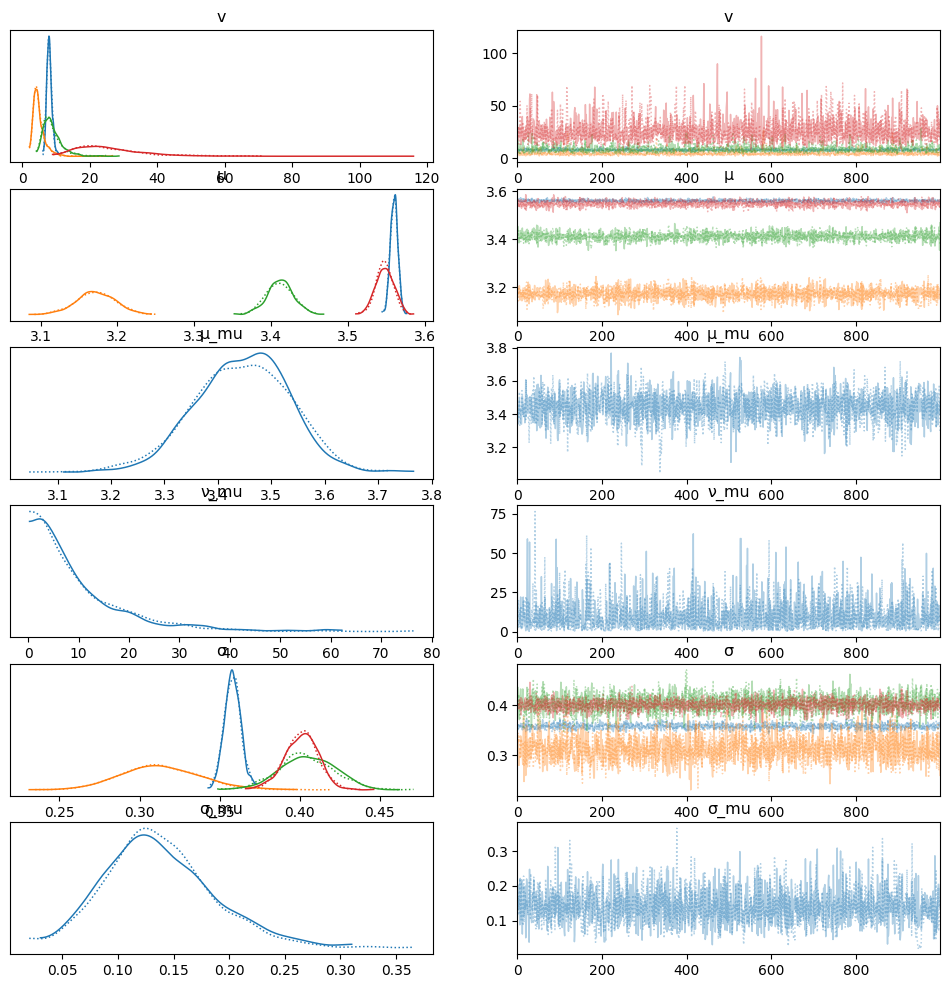

In [ ]:
az.plot_trace(data_network_h1)
az.rhat(data_network_h1)

## Analysis

Let's analyze what we have here.

It is important to first recognize that this model does not account for skew. For that reason, it is NOT the best that we can do. The rightward tail and the means do not match up with this hierarchical model distribution.

The r-hat values are very good since they are all extremely close to 1.0 and fall in the range from 0.9993 to 1.004. Most of the amplitudes match up in the traces, but they are some signifcant outliers in v_mu and some additional outliers in σ_mu.

We are now, also able to observe the concept of shrinkage the hierarchical models display in comparison to the non-hierarchical models. Also, the non-heirarchical model has a very different posterior for the .com category, on the opposite side of the mean. This may help show that the StudentT prior for the non-hierarchcical model is not a solid choice.

Let's try another model.

## **Hierarchical Model #2**

In [8]:
with pm.Model(coords=network_coords) as network_model_h2:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 3, sigma = 1)
    σ_mu = pm.HalfNormal('σ_mu', sigma = 0.1)
    α_mu = pm.Uniform('α_mu', upper = 1.5, lower = 0.5)
    β_mu = pm.Uniform('β_mu', upper = 1, lower = 0)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.SkewStudentT('μ',
                  mu = μ_mu,
                  sigma = σ_mu,
                  a = α_mu,
                  b = β_mu,
                  dims = "pos")

    σ = pm.HalfNormal('σ', sigma = 0.1,
                      dims = "pos")
    a = pm.Uniform('a_mu', upper = 1.5, lower = 0.5, dims="pos")
    b = pm.Uniform('b_mu', upper = 1, lower = 0, dims="pos")

    #likelihood; same as before
    y = pm.SkewStudentT('y', mu=μ[pos_idx], sigma=σ[pos_idx], a=a[pos_idx], b=b[pos_idx],
                    observed=network["url_entropy"])

    #cs for chemshift, h for heirarchical
    data_network_h2 = pm.sample()

Output()

Output()

Output()

(0.0, 5.0)

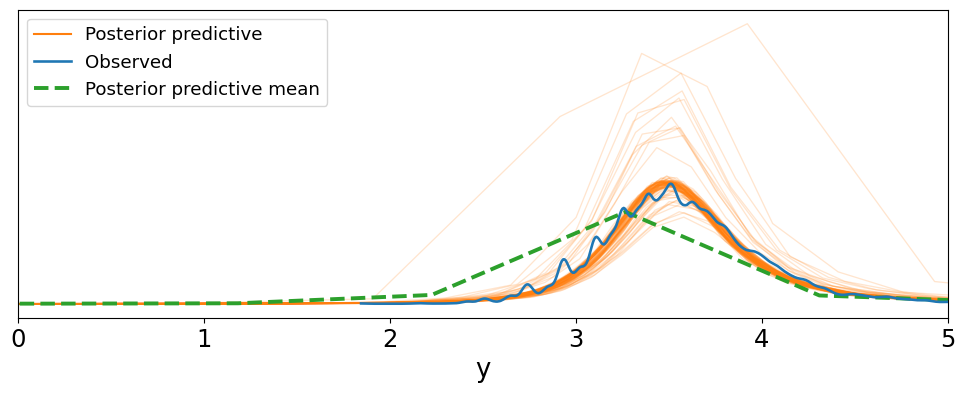

In [16]:
pm.sample_posterior_predictive(data_network_h2, model=network_model_h2, extend_inferencedata=True)

plot = az.plot_ppc(data_network_h2, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])
plot.set_xlim(0, 5)

<xarray.Dataset> Size: 208B
Dimensions:  (pos: 4)
Coordinates:
  * pos      (pos) <U3 48B 'com' 'it' 'net' 'org'
Data variables:
    a_mu     (pos) float64 32B 1.001 1.0 1.0 1.003
    b_mu     (pos) float64 32B 1.001 0.9999 1.001 1.0
    α_mu     float64 8B 0.9995
    β_mu     float64 8B 1.002
    μ        (pos) float64 32B 1.001 1.001 0.9998 1.002
    μ_mu     float64 8B 1.008
    σ        (pos) float64 32B 1.002 1.0 1.001 1.001
    σ_mu     float64 8B 1.002

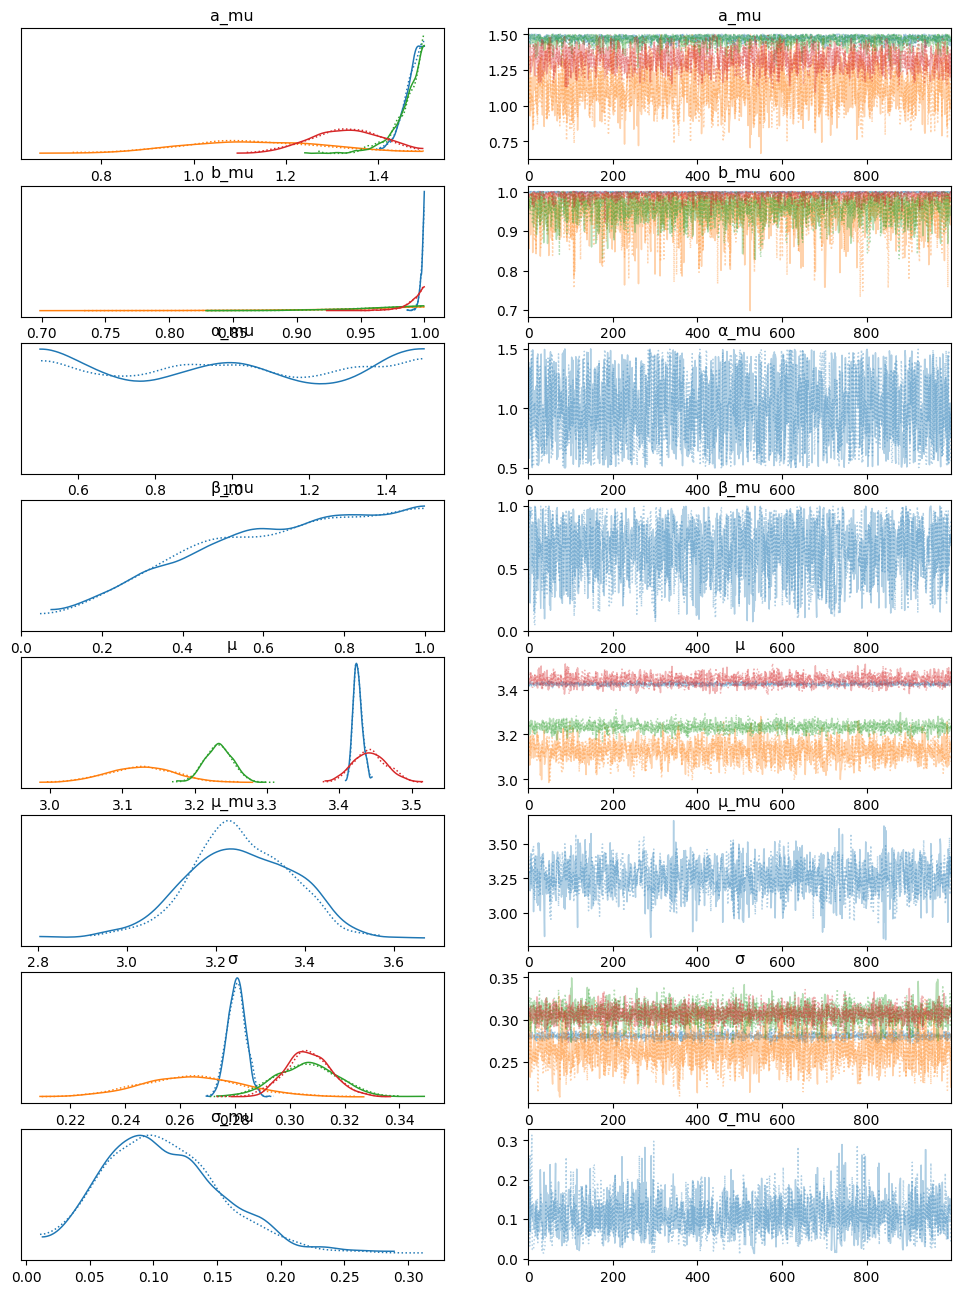

In [17]:
az.plot_trace(data_network_h2)
az.rhat(data_network_h2)

## Analysis

Let's analyze what we have here.

It is important to recognize that we are not creating a heirarchical model that now accounts for skew. Just looking at the individual samples (not the mean), we can observe that the posterior predictive check aligns much better with the observed data.

The r-hat values are very good since they are all extremely close to 1.0. Most of the amplitudes and modes match up in the traces, but they are some signifcant outliers in a_mu, especially for he orange lines. However, the trace looks really good for the rest of the categories.

For now, I will call the SkewStudentT my best model for this

# **Part V: Conclusions**

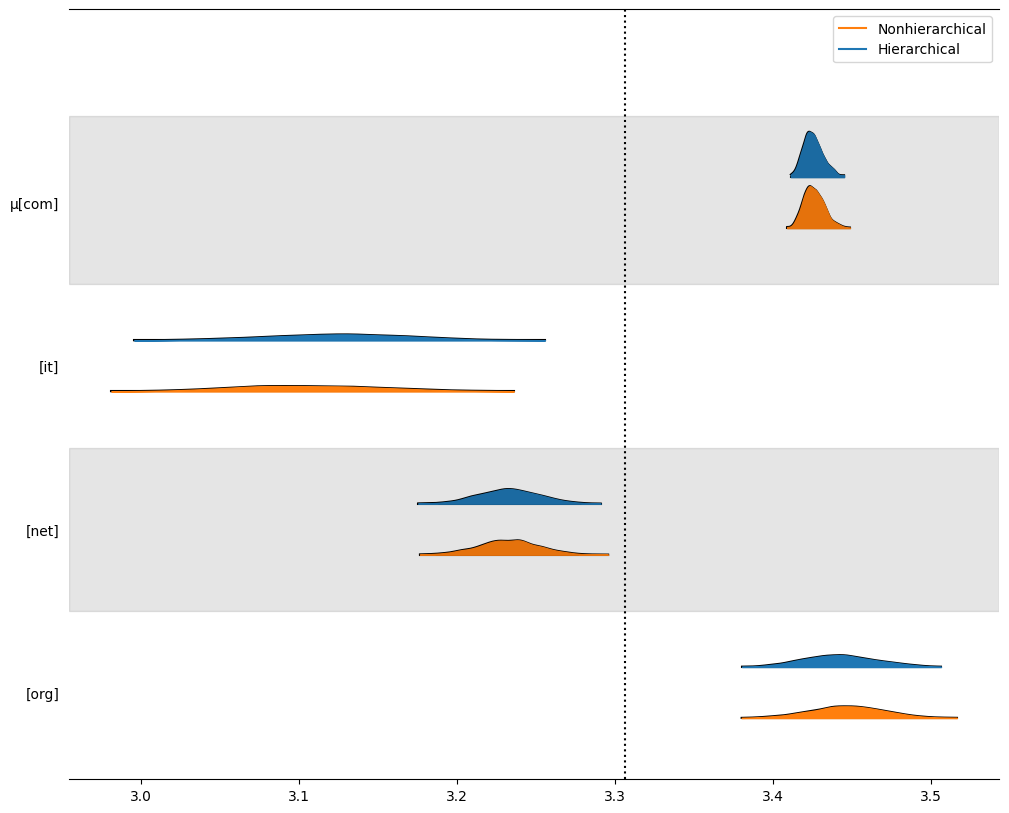

In [21]:
axes = az.plot_forest([data_network_h2, data_network_nh3], kind="ridgeplot",
                      model_names=['Hierarchical', 'Nonhierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(data_network_h2.posterior['μ'].mean(), *y_lims, color="k", ls=":");

I have chosen to plot the ridge plots of the best hierarchical and nonhierarchical model.

Primarily, I noticed that the mean is around 3.3, with the heirarchical model being slightly closer to the mean for the .com, .it, and .org categories. I feel like this value is slightly an overestimate, especially considering that most hackers wil not choose such high entropy values due to improvements in defenses against attackers.

The .com domain had the highest entropy value percentage given the ridge plot. This actually makes a lot of sense in the context of the world. In the real world, a lot of people are able to make websites now. The .com domain is very easy to acquire for a majority of the population, allowing many hackers to make websites with these domains. As a result, it makes  a lot of snese that the .com domain would have a lot of entropy/randomness. This is the outlier for my data, and it makes a lot of sense why this is the case.

The .org also follows a similar trend, and this makes more sense. .org is usually a domain for organizations, but many phishers and scammers make fake organizations to trick people. Thus, the entropy value is a lot higher for the .org domain. However, it is more spread out because there are may legitimate .org websites as well.

The .net domain is below the average entropy values. The net domain is used for technology and networking websites by reputed companies, so it is a bit harder for these urls to have entropy values. Given the context of the real world, this data makes sense and is true to the world.

The .it domain surprised me a little bit. The values were very widespread and extremely below the average entropy value. This was a little interesting to me. Although the .it domain is used for Italy websites, I have personally observed many randomness in these URLS for scam messages, so I thought that the entropy values would be a lot higher. It is interesting to see how my perpection may be biased and my out look on the world is focused in on a specific genre of these websites.

### Analysis on Shrinkage

My results are a bit different than the ones from the answer key.

The heirarchical models did NOT really add that much shrinkage that I was expecting.

Let's talk about why and what this means. So, less shrinkage means that the individual estimates of each group is resisting the pull towards the mean. What this means is that the different domains act like much more independent estimates and is not significantly impacted by incorporating information combined for all groups.

One reason this might be the case is because I have a lot of data. I have around 10,000 data points which may cause my model to develop a high confidence in these individual predictions as opposed to predictions that incorporate data from all categories/groups.

It is interesting because the .com and .org domains have similar results, so the model is most likely NOT having trouble when finding the mean. I think that a lot of the different categories chosen have data that is just very different from each other. Although these URLS have entropy values, they likely differ by a signifcant amount (use of words, numbers and symbols that are unique to each domain). This may result in very small shrinkage due to the uniquness of the data.

For the future, I could try with less data points to see if a similar trend occurs to learn if each groups is more independent that I think. This would be very surprising because it would show that attackers have different biases when forming their attacks and creating thise sense of entropy.